In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import PIL

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
def augment_data(image):
    image = tf.image.resize_with_crop_or_pad(image, 180, 180) # Add 6 pixels of padding
    image = tf.image.random_crop(image, size=[150, 150, 3]) # Random crop back to 28x28
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness

    return image

In [ ]:
#directory = "D:/dataset/flower_photos"

import tensorflow as tf
import os

_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir =  "/root/.keras/datasets/cats_and_dogs_filtered/train"
validation_dir = "/root/.keras/datasets/cats_and_dogs_filtered/validation"

68616192/68606236 [==============================] - 1s 0us/step


In [ ]:
!ls /root/.keras/datasets/cats_and_dogs_filtered/train/cats

cat.0.jpg    cat.250.jpg  cat.400.jpg  cat.551.jpg  cat.701.jpg  cat.852.jpg
cat.100.jpg  cat.251.jpg  cat.401.jpg  cat.552.jpg  cat.702.jpg  cat.853.jpg
cat.101.jpg  cat.252.jpg  cat.402.jpg  cat.553.jpg  cat.703.jpg  cat.854.jpg
cat.102.jpg  cat.253.jpg  cat.403.jpg  cat.554.jpg  cat.704.jpg  cat.855.jpg
cat.103.jpg  cat.254.jpg  cat.404.jpg  cat.555.jpg  cat.705.jpg  cat.856.jpg
cat.104.jpg  cat.255.jpg  cat.405.jpg  cat.556.jpg  cat.706.jpg  cat.857.jpg
cat.105.jpg  cat.256.jpg  cat.406.jpg  cat.557.jpg  cat.707.jpg  cat.858.jpg
cat.106.jpg  cat.257.jpg  cat.407.jpg  cat.558.jpg  cat.708.jpg  cat.859.jpg
cat.107.jpg  cat.258.jpg  cat.408.jpg  cat.559.jpg  cat.709.jpg  cat.85.jpg
cat.108.jpg  cat.259.jpg  cat.409.jpg  cat.55.jpg   cat.70.jpg	 cat.860.jpg
cat.109.jpg  cat.25.jpg   cat.40.jpg   cat.560.jpg  cat.710.jpg  cat.861.jpg
cat.10.jpg   cat.260.jpg  cat.410.jpg  cat.561.jpg  cat.711.jpg  cat.862.jpg
cat.110.jpg  cat.261.jpg  cat.411.jpg  cat.562.jpg  cat.712.jpg  cat.863.jpg
c

In [ ]:
train_dir = pathlib.Path(train_dir)
validation_dir = pathlib.Path(validation_dir)

In [ ]:
CLASS_NAMES = np.array([item.name for item in train_dir.glob('*')])

In [ ]:
CLASS_NAMES

array(['cats', 'dogs'], dtype='<U4')

In [ ]:
CLASS_NAMES = np.array([item.name for item in validation_dir.glob('*')])

In [ ]:
CLASS_NAMES

array(['cats', 'dogs'], dtype='<U4')

In [ ]:
train_dataset = tf.data.Dataset.list_files(str(train_dir/'*/*'))
validation_dataset = tf.data.Dataset.list_files(str(validation_dir/'*/*'))

In [ ]:
#validation_split = 0.2

In [ ]:
TRAIN_SIZE = len(list(train_dataset))
print("Train size: ", TRAIN_SIZE)
val_SIZE = len(list(validation_dataset))
print("Train size: ", val_SIZE)
#train_size = int((1-validation_split) * DATASET_SIZE)
#print("train size: ", train_size)

Train size:  2000
Train size:  1000


In [ ]:
@tf.function
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [ ]:
get_label("/root/.keras/datasets/cats_and_dogs_filtered/train/cats/cat.953.jpg").numpy()

array([ True, False])

In [ ]:
@tf.function
def load_img(image_path):
    img = tf.io.read_file(image_path)
    
    # https://stackoverflow.com/questions/44942729/tensorflowvalueerror-images-contains-no-shape
    img = tf.image.decode_image(img, 3, expand_animations=False)
    
    img = tf.cast(img, tf.float32)
    return img

In [ ]:
# normalizing the images to [-1, 1]
@tf.function
def normalize(image):
    image = (image / 127.5) - 1
    return image

In [ ]:
@tf.function
def resize(image,height, width):
    image = tf.image.resize(image, (height, width),
                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    #image = tf.image.resize_with_crop_or_pad(image, height, width)
    return image

In [ ]:
@tf.function
def load_image_with_label(image_path):
    label = get_label(image_path)
    img = load_img(image_path)
    return img, label

In [ ]:
@tf.function
def load_image_train(image_file):
    image, label = load_image_with_label(image_file)
    image = augment_data(image)
    image = normalize(image)
    
    return image, label

In [ ]:
@tf.function
def load_image_test(image_file):
    image, label = load_image_with_label(image_file)
    image = resize(image, 150, 150)
    image = normalize(image)

    return image, label

In [ ]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [ ]:
AUTOTUNE=tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.map(load_image_train,num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
AUTOTUNE=tf.data.experimental.AUTOTUNE
validation_dataset = validation_dataset.map(load_image_test,num_parallel_calls=AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.cache()
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
base_model = tf.keras.applications.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
n_class =len(CLASS_NAMES)

In [ ]:
flatten_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(100, activation='relu')
dropout_layer = tf.keras.layers.Dropout(0.5)
prediction_layer = tf.keras.layers.Dense(n_class, activation='softmax')




In [ ]:
model = tf.keras.Sequential([
  base_model,
  flatten_layer,
  dense_layer,
  dropout_layer,
  prediction_layer
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.01),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=validation_dataset)

Epoch 1/100
63/63 [==============================] - 54s 271ms/step - loss: 0.7513 - accuracy: 0.7085 - val_loss: 0.5393 - val_accuracy: 0.7150
Epoch 2/100
63/63 [==============================] - 16s 199ms/step - loss: 0.3779 - accuracy: 0.8280 - val_loss: 0.3371 - val_accuracy: 0.8460
Epoch 3/100
63/63 [==============================] - 16s 199ms/step - loss: 0.3213 - accuracy: 0.8535 - val_loss: 0.3666 - val_accuracy: 0.8370
Epoch 4/100
63/63 [==============================] - 16s 200ms/step - loss: 0.3359 - accuracy: 0.8605 - val_loss: 0.3284 - val_accuracy: 0.8780
Epoch 5/100
63/63 [==============================] - 15s 199ms/step - loss: 0.2860 - accuracy: 0.8710 - val_loss: 0.4373 - val_accuracy: 0.8140
Epoch 6/100
63/63 [==============================] - 16s 200ms/step - loss: 0.2909 - accuracy: 0.8675 - val_loss: 0.2339 - val_accuracy: 0.9200
Epoch 7/100
63/63 [==============================] - 15s 199ms/step - loss: 0.2645 - accuracy: 0.8740 - val_loss: 0.6317 - val_accuracy:

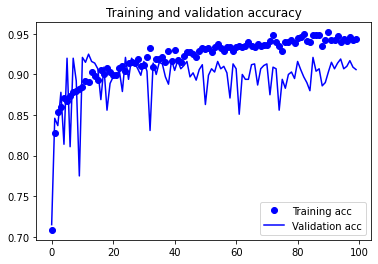

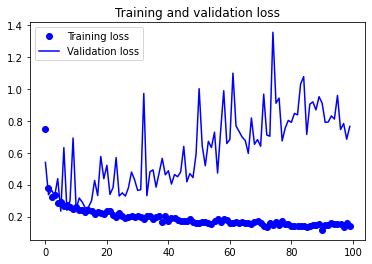

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
model.save('cats_and_dogs_TFDATA.h5')

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [ ]:
#class_names = train_ds.class_names
img = keras.preprocessing.image.load_img(
    '/content/CAT.jpg', target_size=(150, 150)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(CLASS_NAMES[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to cats with a 73.11 percent confidence.


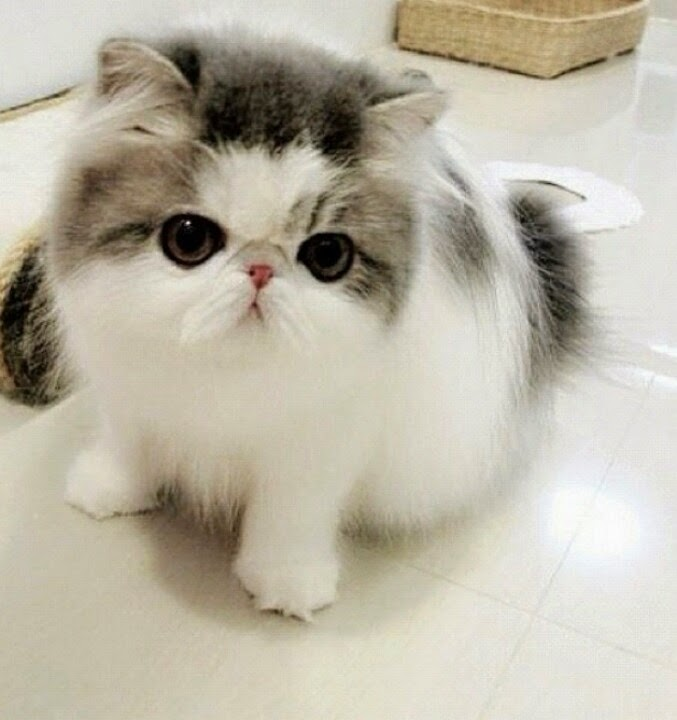

In [ ]:
from IPython.display import Image
Image('CAT.jpg')